# Metoda PDF za določanje stolpcev

<font size="4">Ideja je, da na set podatkov naredimo gaussian kernel density estimation, nato pa glede na ta PDF določamo stevilo stolpcev na posameznih intervalih.

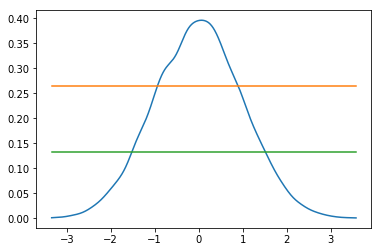

In [10]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.optimize import fmin, fsolve
from math import floor, ceil

random.seed(0)

# normalna porazdelitev
gauss_data = []
for i in range(10000):
    gauss_data.append(random.gauss(0,1))


# pdf
x = np.linspace(min(gauss_data), max(gauss_data), 1000)
p = gaussian_kde(gauss_data)

# srednja vrednost in maksimum pdf
mu = np.mean(gauss_data)
maks = p(mu)

# za zacetek vzemimo 3 utezi
obm1 = maks * 2/3
obm2 = maks * 1/3

# izris mej za utezi
obm1_izris = [obm1 for _ in x]
obm2_izris = [obm2 for _ in x]

plt.plot(x,p(x))
plt.plot(x,obm1_izris)
plt.plot(x,obm2_izris)

plt.show()

<font size="4">Sestavimo funkcijo f, ki vrne vrednosti na intervalih, kjer je pdf večji/manjši od dolocene meje. Nato poglejmo, kakšne so vrednosti funkcije f na teh intervalih. Potem poiščemo intervale, na katerih ima f konstantno vrednost.

In [2]:
from optimalBinNumber import optBinNum

# definiramo funkcijo f, ki bo povedala, kaksna bo utez na intervalih pod obmocji
def f(x):
    if p(x)>=obm1:
        return 0.5
    elif obm1>p(x)>=obm2:
        return 0.3
    elif obm2>p(x)>0:
        return 0.2
    else:
        return 0

# pogledamo, kaksne so vrednosti funkcije f na intervalu [min,max]
vals = []
korak = np.std(gauss_data)/10

for i in np.arange(min(gauss_data)-korak,max(gauss_data)+korak,korak):
    vals.append((i,f(i)))


# poiscimo intervale, kjer je vrednost funkcije f konstantna
to_compare = vals[0]
intervals = []
a = to_compare[0]
b = None

for i in range(len(vals)-1):
    if vals[i][1] != to_compare[1]:
        b = vals[i-1][0]
        intervals.append((a,b,to_compare[1]))
        to_compare = vals[i]
        a = b
        b = None
    
intervals.append((a,vals[-1][0],to_compare[1]))

print(*intervals,sep="\n")

(-3.4414798562214743, -1.5464976755832294, 0.2)
(-1.5464976755832294, -0.9480822501185204, 0.3)
(-0.9480822501185204, 0.8471640262756059, 0.5)
(0.8471640262756059, 1.4455794517403158, 0.3)
(1.4455794517403158, 3.6397693451109143, 0.2)


<font size="4">Sedaj z uporabo teh intervalov in vrednosti funkcije f na teh intervalih določimo meje stolpcev našega histograma.

In [3]:
# dolocimo meje stolpcev nasega histograma
stolpci = []
optimalno_staticno = optBinNum(gauss_data) # scott metoda za dolocanje stevilo stolpcev
first = intervals[0][0] # spodnja meja histograma
last = intervals[-1][1] # zgornja meja histograma
d = last - first # dolzina intervala, kjer je histogram definiran

for el in intervals:
    st_stolpcev_na_int = ceil(2*el[2]*(el[1]-el[0])*optimalno_staticno/d) #trojka iz tistih tretjin
    array_to_append = np.linspace(el[0],el[1],st_stolpcev_na_int, endpoint=False)
    stolpci.append(array_to_append)

stolpci = list(np.concatenate(stolpci))
stolpci.append(intervals[-1][1])

print(*stolpci,sep="\n")

print("\nStevilo stolpcev: ", len(stolpci))

-3.4414798562214743
-3.0624834200938253
-2.6834869839661764
-2.3044905478385274
-1.9254941117108784
-1.5464976755832294
-1.347025867094993
-1.1475540586067567
-0.9480822501185204
-0.7848780431735999
-0.6216738362286793
-0.4584696292837587
-0.2952654223388381
-0.13206121539391757
0.031142991551003085
0.19434719849592352
0.3575514054408442
0.5207556123857648
0.6839598193306853
0.8471640262756059
1.0466358347638425
1.2461076432520792
1.4455794517403158
1.8112777673020821
2.1769760828638485
2.542674398425615
2.908372713987381
3.2740710295491477
3.6397693451109143

Stevilo stolpcev:  29


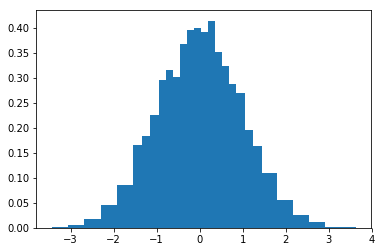

In [4]:
plt.hist(gauss_data, bins=stolpci, density=1)
plt.show()

<font size="4">To metodo bomo implementirali v datoteko optimalBinNumber.py kot funkcijo dynamic_bins.

# Testiranje na modelu gaussovskih mešanic

<font size="4">Testirajmo našo metodo na modelih gaussovskih mešanic.

Stevilo stolpcev:  30


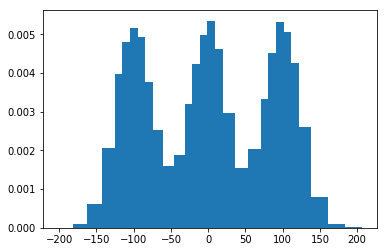

In [6]:
from optimalBinNumber import dynamicBins
from GMM import GMM

gmm = GMM([[-100,5],[0,5],[100,5]], 20000)

bins = dynamicBins(gmm)
print("Stevilo stolpcev: ",len(bins))

plt.hist(gmm,bins=bins,density=1)
plt.show()

<font size="4">Metoda deluje. Poglejmo še malo bolj občutljiv problem: normalna porazdelitev s "pokvarjenim repom".

Stevilo stolpcev:  21


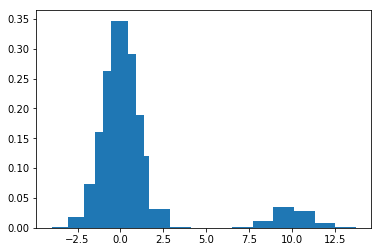

In [11]:
normRep = GMM([[0,1],[10,1]], 10000, [0.9,0.1])
bins1 = dynamicBins(normRep)
print("Stevilo stolpcev: ",len(bins1))

plt.hist(normRep,bins=bins1,density=1)
plt.show()

Stevilo stolpcev:  46


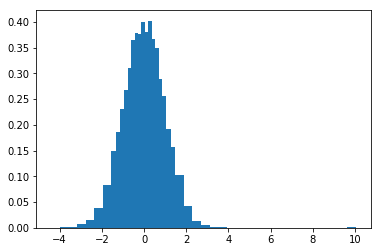

In [8]:
normRep2 = GMM([[0,1],[10,0.01]], 10000, [0.999,0.001])
bins2 = dynamicBins(normRep2)
print("Stevilo stolpcev: ",len(bins2))

plt.hist(normRep2,bins=bins2,density=1)
plt.show()

<font size="4">Postavimo drugačne uteži, da bomo videli podrobnosti v repu porazdelitve.

Stevilo stolpcev:  107


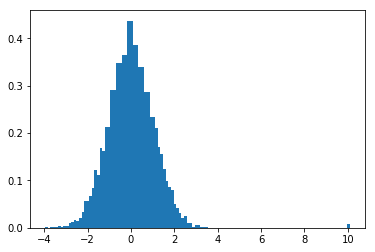

In [9]:
normRep3 = GMM([[0,1],[10,0.01]], 10000, [0.999,0.001])
bins3 = dynamicBins(normRep3, weights=[0.3,0.7])
print("Stevilo stolpcev: ",len(bins3))

plt.hist(normRep3,bins=bins3,density=1)
plt.show()